In [1]:
import sys
import os
from sklearn import preprocessing
from dtaidistance import dtw
from matplotlib.colors import ListedColormap
from matplotlib import cm
from obspy import Stream, Trace, read
from msnoise.api import *
from clusterCCFs_msnoise import *
import matplotlib.pyplot as plt

Define parameters for CCFs that are intended to be clustered

In [2]:
msnoisedir = '/home/yatesal/msnoise/piton04' #set msnoise directory
filterid=2 #set filter id
mov_stack=10 #set stack size
pair = 'YA.UV05.00:YA.UV12.00' #define station pair
startdate = '2010-01-01'
enddate = '2011-04-01'
comp='ZZ' #component to cluster
step = 2 #gap in days between CCFs to cluster

Read CCFs, storing them as numpy array

In [3]:
os.chdir(msnoisedir)
db = connect()
params = get_params(db)

#convert string dates to datetime64
startdatedt = np.datetime64(startdate)
enddatedt = np.datetime64(enddate)

#create array of datetimes between start and enddate, spaced by defined step
days = np.arange(startdatedt, enddatedt, np.timedelta64(step, 'D'))

sta1 = pair.split(":")[0]
sta2 = pair.split(":")[1]

st = Stream()

for i, day in enumerate(days):

    stackpath = "STACKS/{:02d}/{:03d}_DAYS/{}/{}_{}/{}.MSEED".format(filterid,mov_stack,comp,sta1,sta2,day)
    
    if os.path.isfile(stackpath):
        st += read(stackpath)
    else:
        print(stackpath +' missing')

        
ccfs = np.array(st)   

Compute distance matrix from ccfs. 

Currently implemented options in code are 'euclid' (euclidean distance), 'cc' (correlation coefficient, or 1- CC for dissimilarity) and 'ccstretch'. This will stretch all waveforms relative to eachother, and record the maximum correlation coefficient to calculate dissimilarity (1-max(CC)). The intention here is to 'correct' for larger dv/v changes that could influence clustering results.

For distmethod = 'ccstretch', can define dvv_max and dvv_step. The values of stretch tested will then be from -dvv_max to +dvv_max in increments of dvv_step. Increasing dvv_max, or reducing dvv_step, will increase computation time. 

In [4]:
distmethod = 'cc' #euclid, cc, ccstretch

#for distmethod='ccstretch'
dvv_max=0.01 #0.01 = 1%
dvv_step=0.0001
dvvparams = [dvv_max, dvv_step]

minlagwin = 20 #minimum lag
maxlagwin = 50 #maximum lag
sides = 'both' #B (both, default), P (positive), N (negative)
norm=False #normalize CCFs

D = get_DMatrix(ccfs, params, distmethod, minlagwin, maxlagwin, norm=norm, dvvparams=dvvparams)

Perform hierarchical clustering on distance matrix, and show dendrogram

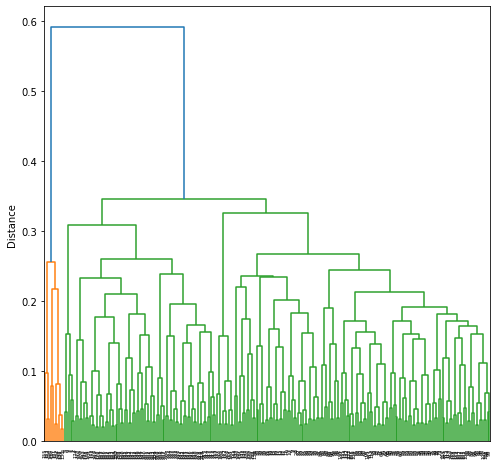

In [5]:
linkagemethod='average' #single, complete, average, ward

fig, ax = plt.subplots(figsize=(8,8))
ax.set_ylabel('Distance')

H = hierarchy.linkage(squareform(D), method=linkagemethod)
dn = hierarchy.dendrogram(H, ax=ax)

Plot interferogram from CCFs, also showing position in time of clusters for a defined threshold.

Figure(864x864)
AxesSubplot(0.125,0.657941;0.775x0.222059)


/home/yatesal/cluster_CCFs/clusterCCFs_msnoise.py:234: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(df.index, df.columns, df.values.T, vmin=-clim, vmax=clim, rasterized=True,cmap='seismic')


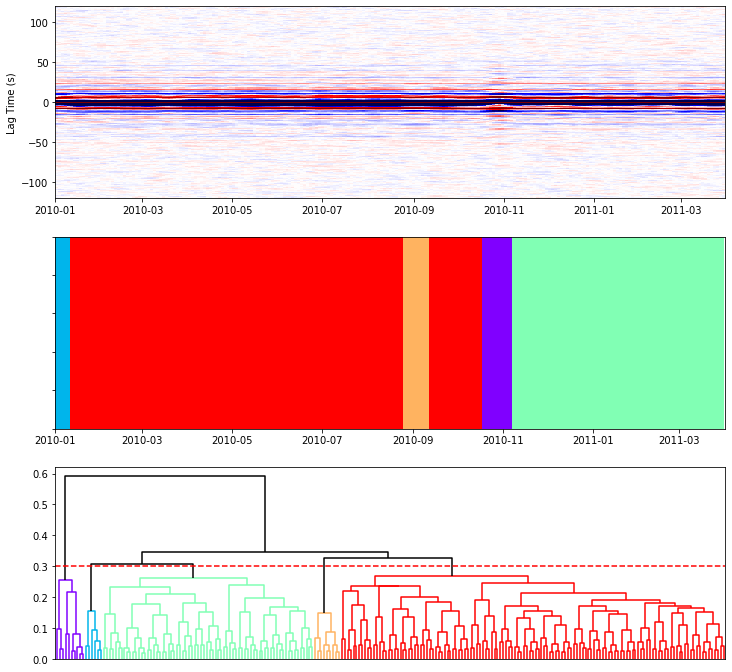

In [6]:
#set static threshold to show location of clusters in time
threshold = 0.3

# Plot interferogram, dendrogram and cluster positions

fig, ax = plt.subplots(3,1, figsize=(12,12))

plot_interferogram(ccfs, params, days, fig=fig, ax=ax[0], maxlag=60)

#get labels corresponding to distance threshold
labels = hierarchy.fcluster(H, threshold, criterion='distance')
num_fam = np.max(labels) #no. clusters
cmap = plt.get_cmap('rainbow')
color_range = cmap(np.linspace(0.0, 1.0, int(num_fam)))

#plot cluster labels
for d in range(len(days)):     
    if d == 0:
        continue
    else:
        diff = (days[d]-days[d-1])/np.timedelta64(1,'D')
        if int(diff) == step:
            ax[1].axvspan(days[d-1], days[d], color=color_range[labels[d]-1], alpha=1.0, lw=0)

ax[1].set_yticklabels([])
ax[1].set_xlim(np.datetime64(startdate), np.datetime64(enddate))

#plot dendrogram
hierarchy.set_link_color_palette([cm.colors.rgb2hex(rgb) for rgb in color_range])
dn = hierarchy.dendrogram(H, color_threshold=threshold, above_threshold_color='black', no_labels=True, ax=ax[2])
ax[2].axhline(y=threshold, color='red', linestyle='dashed')
